# Praca domowa 2
Celem projektu jest wybranie bazy danych, obróbki i przetestowanie na niej, jak działają na niej poznane algorytmy. Wybrałam bazę danych zdjęć, które mają dwie kategorie. Kategoria pierwsza to emocje szczęścliwe/radosne (happy), a druga kategoria to emocje smutne/zmartwione (sad). Baza danych składa się z dwóch folderów - happy/sad. Na zdjęciach są przedstawione twarze przeróżnych osób, w przeróżnych kątach.

Do ekperymentu wybrałam bibliotekę keras.

In [261]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

In [262]:
sad_path = './train/sad'
happy_path = './train/happy'

### Obróbka bazy danych
Pierwsze załadowanie zdjęć wykonuję bez obróbki bazy danych, ponieważ zdjęcia są czarno-białe i mają wielkość 48x48, czyli są idealne by testować na nich modele sieci neuronowej. Przy drugiej bazie danych obrobimy je na parę sposobów.

In [263]:
# Preparing data
def load_images_labels(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, filename))
        if img is not None:
            images.append(img)
            labels.append(label)
    return images, labels


sad_images, sad_labels = load_images_labels(sad_path, 0)
happy_images, happy_labels = load_images_labels(happy_path, 1)

images = sad_images + happy_images
labels = sad_labels + happy_labels

X = np.array(images)
Y = np.array(labels)
print(X.shape, Y.shape)

(12102, 48, 48, 3) (12102,)


`train_datagen` to instancja klasy `ImageDataGenerator` z biblioteki `Keras`, która służy do generowania przetworzonych (augmentowanych) obrazów na podstawie oryginalnego zbioru danych treningowych. Augmentacja danych to technika stosowana w celu sztucznego zwiększenia rozmiaru zbioru danych, poprzez wprowadzenie losowych przekształceń obrazów, takich jak obrót, przesunięcie, skalowanie czy odbicie lustrzane. Dzięki temu model uczy się rozpoznawać różne warianty obrazów, co zwiększa jego zdolność generalizacji.

1. rescale: Współczynnik skalowania wartości pikseli, w tym przypadku normalizacja wartości do zakresu 0-1.
2. rotation_range: Zakres losowego obrotu obrazów (w stopniach).
3. width_shift_range: Zakres losowego przesunięcia w poziomie (jako ułamek szerokości obrazu).
4. height_shift_range: Zakres losowego przesunięcia w pionie (jako ułamek wysokości obrazu).
5. shear_range: Zakres losowego przekształcenia ścinającego (w radianach).
6. zoom_range: Zakres losowego przybliżenia/oddalenia obrazu.
7. horizontal_flip: Wartość logiczna określająca, czy stosować losowe odbicie lustrzane w poziomie.
8. fill_mode: Metoda wypełniania nowo utworzonych pikseli po przekształceniu, w tym przypadku 'nearest' oznacza użycie najbliższego piksela.

In [264]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255) # bez augmentacji, tylko normalizacja


### Podział danych na dane treningowe, testowe i walidacyjne

In [265]:
# Podzielenie danych na zbiór uczący, walidacyjny i testowy
X_train_temp, X_val_test, y_train_temp, y_val_test = train_test_split(X, Y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Dopasowanie generatorów do danych
train_generator = train_datagen.flow(X_train_temp, y_train_temp, batch_size=32)
val_generator = test_datagen.flow(X_val, y_val, batch_size=32)
test_generator = test_datagen.flow(X_test, y_test, batch_size=32, shuffle=False)



### Pokazanie jak obrazki są przeskalowane, by zwiększyć dane do obróbki treningowej

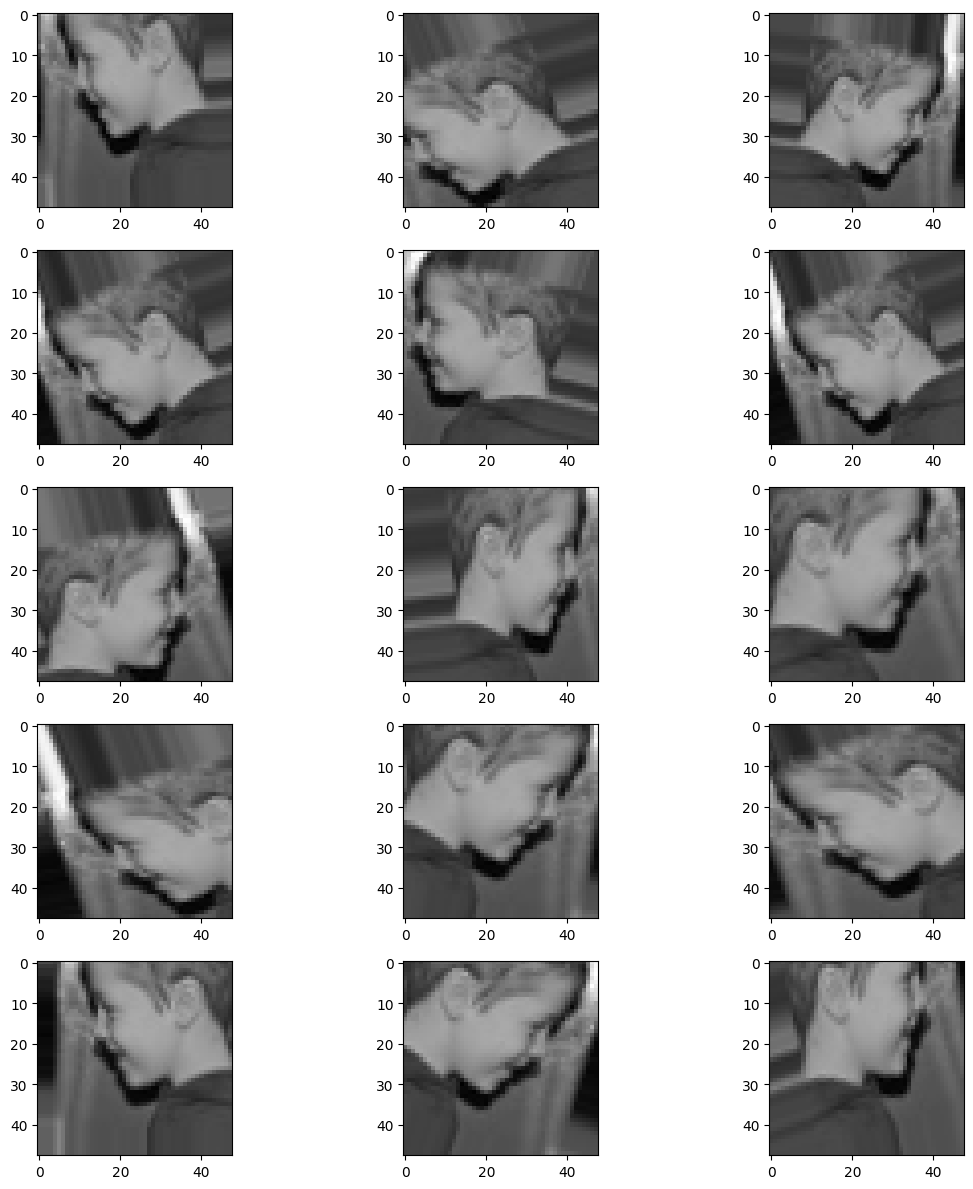

In [266]:
import numpy as np

def plot_transformed_single_image(train_datagen, image_index, num_transformations=15):
    # Pobierz oryginalny obrazek z danych treningowych
    original_image = X_val[image_index]

    # Stworzenie generatora opartego na jednym obrazku
    single_image_gen = train_datagen.flow(np.array([original_image]))

    plt.figure(figsize=(12, 12))
    for i in range(num_transformations):
        plt.subplot(5, 3, i + 1)
        transformed_image = single_image_gen.next()[0]
        transformed_image = transformed_image * 255  # Przeskalowanie wartości pikseli do zakresu 0-255
        plt.imshow(transformed_image.astype(np.uint8))
    plt.tight_layout()
    plt.show()

# Wybierz losowy indeks obrazka
random_image_index = np.random.randint(0, len(X_val))

# Wywołaj funkcję, aby wyświetlić różne wersje przekształceń dla jednego obrazka
plot_transformed_single_image(train_datagen, random_image_index)



# Jak dane się między sobą różnią?

In [267]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from sklearn.metrics import confusion_matrix

Tworzymy dataframe by ukazać różnicę danych. Smutne zdjęcia mają kategorię '0',a wesołe '1'.

In [268]:
happy_path = os.path.join("train", "happy")
sad_path = os.path.join("train", "sad")
filenames_happy = os.listdir(happy_path)
filenames_sad = os.listdir(sad_path)

categories = []
for filename in filenames_happy:
    categories.append(1)

for filename in filenames_sad:
    categories.append(0)

df = pd.DataFrame({
    'filename': filenames_happy + filenames_sad,
    'category': categories
})

df

,filename,category
0,100.jpg,1
1,10000.jpg,1
2,10001.jpg,1
3,10005.jpg,1
4,10035.jpg,1
...,...,...
12097,9966.jpg,0
12098,9974.jpg,0
12099,9976.jpg,0
12100,9986.jpg,0


<Axes: >

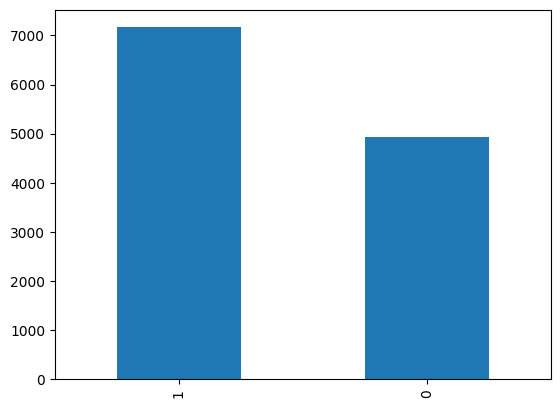

In [269]:
df['category'].value_counts().plot.bar()

Widzimy tutaj, że nasza baza danych mieści w sobie około kilkanastu tysięcy zdjęć, w tym 7 tysięcy happy i 5 tysięcy sad.

Text(0.5, 1.0, 'Sad')

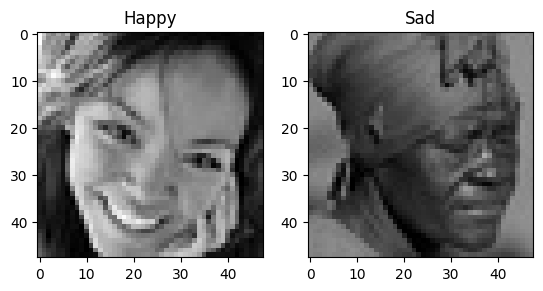

In [270]:
sample_happy = random.choice(filenames_happy)
sample_sad = random.choice(filenames_sad)
image_happy = load_img(os.path.join(happy_path, sample_happy))
image_sad = load_img(os.path.join(sad_path, sample_sad))

plt.subplot(1, 2, 1)
plt.imshow(image_happy)
plt.title("Happy") 

plt.subplot(1, 2, 2)
plt.imshow(image_sad)
plt.title("Sad")

Powyżej jest przykład zdjęcia happy i zdjęcia sad.

### Liczba epok
By porównywanie klasyfikatorów miało sens, każdy model przećwiczę taką samą ilością razy. Dlaczego ustawiam liczbę epok na stałą równą 100

In [271]:
LICZBA_EPOK = 100

# Tworzenie modelu 1 dla bazy danych 1

Najbardziej znany i efektywny model do nauki sieci neuronowej zdjęć jest CNN - konwolucyjna sieć neuronowa. 
Mój model składa się z następujących warstw:
- `Conv2D(32, (3, 3), activation='relu', input_shape=(48,48,3))`: Pierwsza warstwa konwolucyjna z 32 filtrami o rozmiarze 3x3, funkcją aktywacji ReLU i oczekiwanym kształtem wejścia 48x48x3 (wysokość x szerokość x głębokość).
- `BatchNormalization()`: Warstwa normalizacji wsadowej, która poprawia stabilność i szybkość uczenia się sieci.
-` MaxPooling2D(pool_size=(2,2))`: Warstwa max-pooling, która redukuje wymiary przestrzenne (wysokość i szerokość) obrazów o połowę, zwiększając inwariantność na translacje.
- `Dropout(0.25)`: Warstwa dropout, która pomaga w zapobieganiu przeuczeniu, wyłączając losowo 25% neuronów podczas treningu.

Następne dwie sekcje (warstwy 5-8 oraz 9-12) mają podobną strukturę, ale zwiększają liczbę filtrów w warstwach konwolucyjnych (64, a potem 128).

- `Flatten()`: Warstwa spłaszczająca, która konwertuje wielowymiarowe mapy cech na jednowymiarowy wektor.
- `Dense(512, activation='relu')`: Warstwa gęsto połączona (fully connected) z 512 neuronami i funkcją aktywacji ReLU.
- `BatchNormalization()`: Kolejna warstwa normalizacji wsadowej.
- `Dropout(0.5)`: Warstwa dropout, która wyłącza losowo 50% neuronów podczas treningu.
-` Dense(2, activation='softmax')`: Wyjściowa warstwa gęsto połączona z 2 neuronami (odpowiadającymi dwóm klasom) i funkcją aktywacji softmax, która konwertuje wyniki na prawdopodobieństwa przynależności do każdej z klas.

Model jest kompilowany z optymalizatorem `Adam`, funkcją straty `'sparse_categorical_crossentropy'` (odpowiednia dla problemów klasyfikacji wieloklasowej) oraz metryką 'accuracy' do oceny skuteczności modelu.

In [272]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48,48,3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 46, 46, 32)        896       
                                                                 
 batch_normalization_63 (Bat  (None, 46, 46, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 dropout_66 (Dropout)        (None, 23, 23, 32)        0         
                                                                 
 conv2d_31 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 batch_normalization_64 (Bat  (None, 21, 21, 64)     

Poniżej uczymy nasz model dodając mu `val_generator` i `train_generator`

In [273]:
# Liczba próbek podzielona przez rozmiar wsadu
steps_per_epoch = len(X_train_temp) // 32
validation_steps = len(X_val) // 32

# Trenowanie modelu
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=LICZBA_EPOK,
    validation_data=val_generator,
    validation_steps=validation_steps
)



Epoch 1/100
226/226 [==============================] - 24s 99ms/step - loss: 1.0064 - accuracy: 0.5532 - val_loss: 0.9836 - val_accuracy: 0.5917
Epoch 2/100
226/226 [==============================] - 22s 95ms/step - loss: 0.7514 - accuracy: 0.5756 - val_loss: 0.6646 - val_accuracy: 0.6079
Epoch 3/100
226/226 [==============================] - 21s 94ms/step - loss: 0.6863 - accuracy: 0.6040 - val_loss: 0.6105 - val_accuracy: 0.6646
Epoch 4/100
226/226 [==============================] - 21s 95ms/step - loss: 0.6696 - accuracy: 0.6091 - val_loss: 0.6756 - val_accuracy: 0.5983
Epoch 5/100
226/226 [==============================] - 21s 95ms/step - loss: 0.6604 - accuracy: 0.6183 - val_loss: 0.6426 - val_accuracy: 0.6433
Epoch 6/100
226/226 [==============================] - 22s 95ms/step - loss: 0.6418 - accuracy: 0.6394 - val_loss: 0.6488 - val_accuracy: 0.6283
Epoch 7/100
226/226 [==============================] - 21s 94ms/step - loss: 0.6313 - accuracy: 0.6520 - val_loss: 1.5779 - val_ac

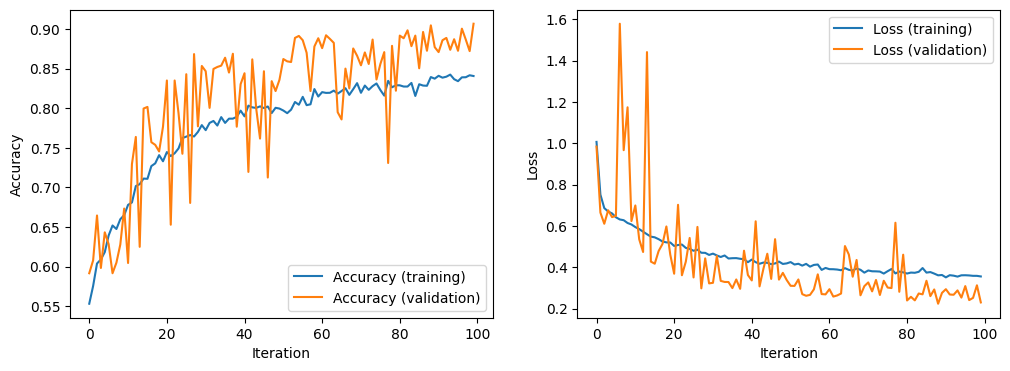

In [274]:
# Plots of accuracy and loss
plt.figure(figsize=(12, 4))
# plt.title("Baza danych 1 Model 1")
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy (training)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation)')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss (training)')
plt.plot(history.history['val_loss'], label='Loss (validation)')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

Nauka na 100 epokach trwała ponad 35 minut. Funkcja Accuracy Validation jest bardzo niestabilna. Dzieje się tak, ponieważ baza danych jest bardzo zróżnicowana. Jest duża wariancja danych - jeśli dane są bardzo zróżnicowane, może to prowadzić do niestabilnych wyników walidacyjnych.

76/76 [==============================] - 2s 22ms/step
Test accuracy: 0.9008674101610905


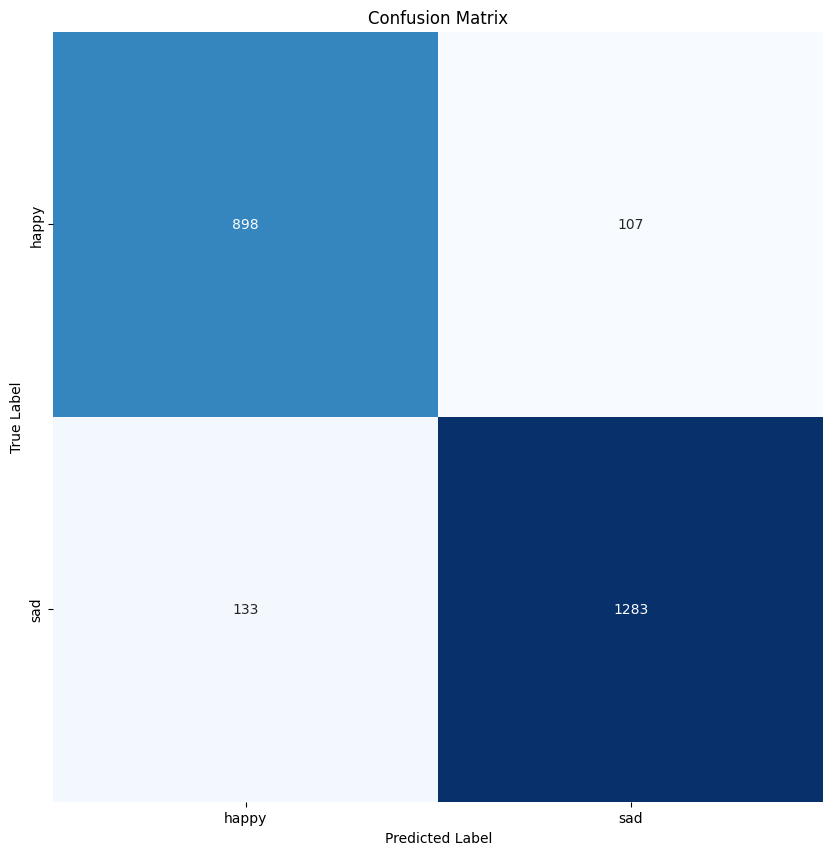

In [275]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import seaborn as sns


# Dokonaj predykcji na zbiorze testowym
predictions = model.predict(test_generator)

# Przekształć predykcje na etykiety (0 lub 1)
predicted_labels = np.argmax(predictions, axis=1)

accuracy_test = accuracy_score(y_test, predicted_labels)
print("Test accuracy:", accuracy_test)


# Oblicz macierz pomyłek
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted_labels)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", square=True, cbar=False,
            xticklabels=["happy", "sad"], yticklabels=["happy", "sad"])

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix")

plt.show()

# Test accuracy dla modelu 1 baza danych 1
Mimo wszystko model bardzo ładnie się nauczył i ukazał dla danych testowych accuracy równe ponad 90%.
Poniżej przedstawiam przykładowe 9 zdjęć z wynikiem czy model rozpoznał zdjęcia bądź nie.

1/1 [==============================] - 0s 29ms/step


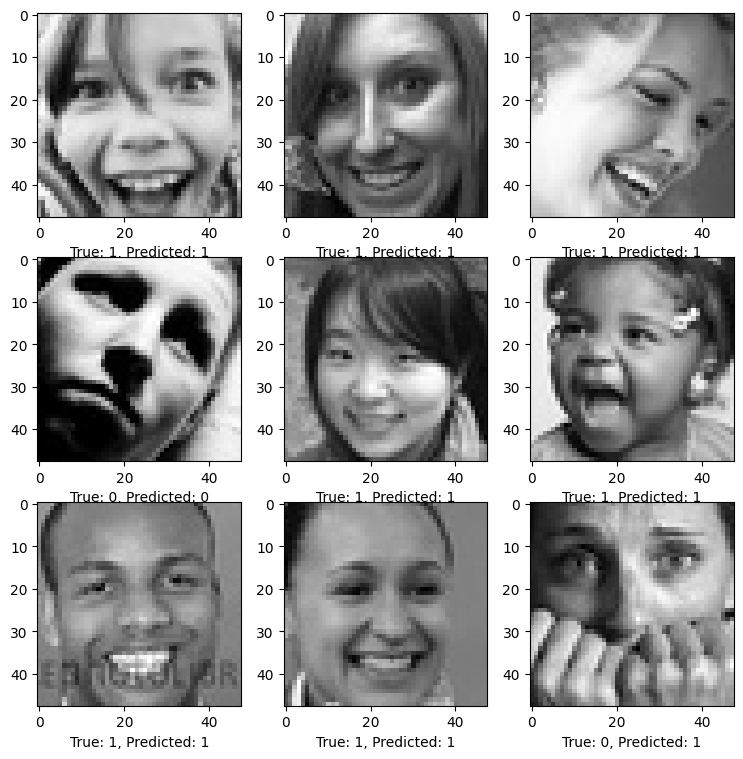

In [276]:
from tensorflow.keras.preprocessing.image import array_to_img
import random

def predict_category(model, img_array):
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    return np.argmax(prediction)

# Weź ranodmowe 9 próbek

sample_test_images = X_test[100:109]
sample_test_labels = y_test[100:109]

plt.figure(figsize=(9,9))

for index, (img_array, true_category) in enumerate(zip(sample_test_images, sample_test_labels)):
    img = array_to_img(img_array)
    predicted_category = predict_category(model, img_array / 255.0)
    
    plt.subplot(3, 3, index + 1)
    plt.imshow(img)
    plt.xlabel(f"True: {true_category}, Predicted: {predicted_category}")

plt.show()


# Model 2 dla bazy danych 1

Jednym ze znanych modelu do nauki sieci neuronowych jest DNN - głęboka sieć neuronowa. Poniższy model składa się z następujących warst:
- `Flatten(input_shape=(48,48,3))`: Warstwa wejściowa spłaszczająca, która konwertuje wejściowe obrazy o kształcie 48x48x3 (wysokość x szerokość x głębokość) na jednowymiarowy wektor.

- `Dense(512, activation='relu')`: Pierwsza ukryta warstwa gęsto połączona (fully connected) z 512 neuronami i funkcją aktywacji ReLU.

-` BatchNormalization()`: Warstwa normalizacji wsadowej, która poprawia stabilność i szybkość uczenia się sieci.

- `Dropout(0.25)`: Warstwa dropout, która pomaga w zapobieganiu przeuczeniu, wyłączając losowo 25% neuronów podczas treningu.

Następne dwie sekcje (warstwy 5-8 oraz 9-12) mają podobną strukturę, ale zmniejszają liczbę neuronów w warstwach gęsto połączonych (256, a potem 128).

- `Dense(2, activation='softmax')`: Wyjściowa warstwa gęsto połączona z 2 neuronami (odpowiadającymi dwóm klasom: szczęśliwa i smutna) i funkcją aktywacji softmax, która konwertuje wyniki na prawdopodobieństwa przynależności do każdej z klas.

Model jest kompilowany z optymalizatorem Adam, funkcją straty 'sparse_categorical_crossentropy' (odpowiednia dla problemów klasyfikacji wieloklasowej) oraz metryką 'accuracy' do oceny skuteczności modelu.

In [277]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalization

model2 = Sequential()

# Input layer
model2.add(Flatten(input_shape=(48,48,3)))

# Hidden layers
model2.add(Dense(512, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))

model2.add(Dense(256, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))

model2.add(Dense(128, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))

# Output layer
model2.add(Dense(2, activation='softmax')) # 2 because we have happy and sad classes


model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model2.summary()


Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_26 (Flatten)        (None, 6912)              0         
                                                                 
 dense_88 (Dense)            (None, 512)               3539456   
                                                                 
 batch_normalization_67 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_70 (Dropout)        (None, 512)               0         
                                                                 
 dense_89 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_68 (Bat  (None, 256)              1024      
 chNormalization)                                    

In [278]:
# Liczba próbek podzielona przez rozmiar wsadu
steps_per_epoch = len(X_train_temp) // 32
validation_steps = len(X_val) // 32

history2 = model2.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=LICZBA_EPOK,
    validation_data=val_generator,
    validation_steps=validation_steps
)


Epoch 1/100
226/226 [==============================] - 16s 60ms/step - loss: 0.8097 - accuracy: 0.5536 - val_loss: 0.6762 - val_accuracy: 0.5838
Epoch 2/100
226/226 [==============================] - 13s 57ms/step - loss: 0.7136 - accuracy: 0.5706 - val_loss: 0.6512 - val_accuracy: 0.6175
Epoch 3/100
226/226 [==============================] - 13s 58ms/step - loss: 0.6928 - accuracy: 0.5784 - val_loss: 0.6529 - val_accuracy: 0.6183
Epoch 4/100
226/226 [==============================] - 13s 58ms/step - loss: 0.6761 - accuracy: 0.5923 - val_loss: 0.6472 - val_accuracy: 0.6154
Epoch 5/100
226/226 [==============================] - 13s 58ms/step - loss: 0.6704 - accuracy: 0.5984 - val_loss: 0.6497 - val_accuracy: 0.6067
Epoch 6/100
226/226 [==============================] - 13s 57ms/step - loss: 0.6650 - accuracy: 0.6035 - val_loss: 0.6469 - val_accuracy: 0.6296
Epoch 7/100
226/226 [==============================] - 13s 56ms/step - loss: 0.6668 - accuracy: 0.6020 - val_loss: 0.6516 - val_ac

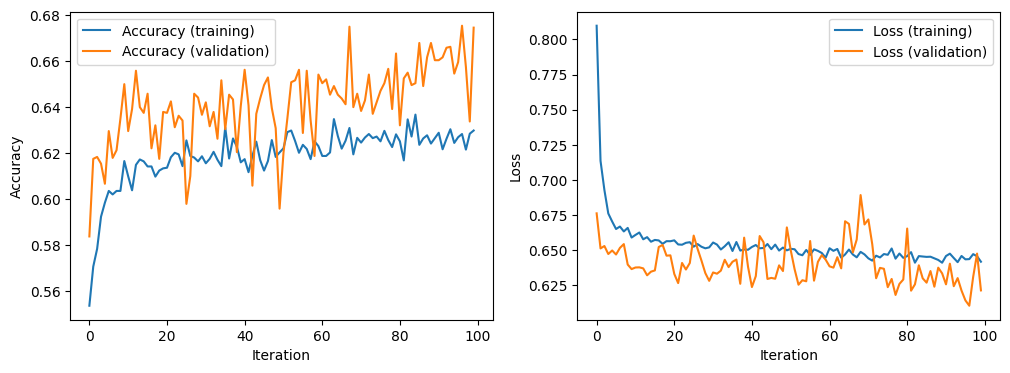

In [279]:
# Plots of accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Accuracy (training)')
plt.plot(history2.history['val_accuracy'], label='Accuracy (validation)')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Accuracy')


plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Loss (training)')
plt.plot(history2.history['val_loss'], label='Loss (validation)')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

Na próbkach treningowych i walidacyjncyh accuracy jest zdecydowanie niższe mimo tej samej ilości epok i działaniu na tych samych zdjęciach.

76/76 [==============================] - 1s 6ms/step
Test accuracy: 0.6757538207352334


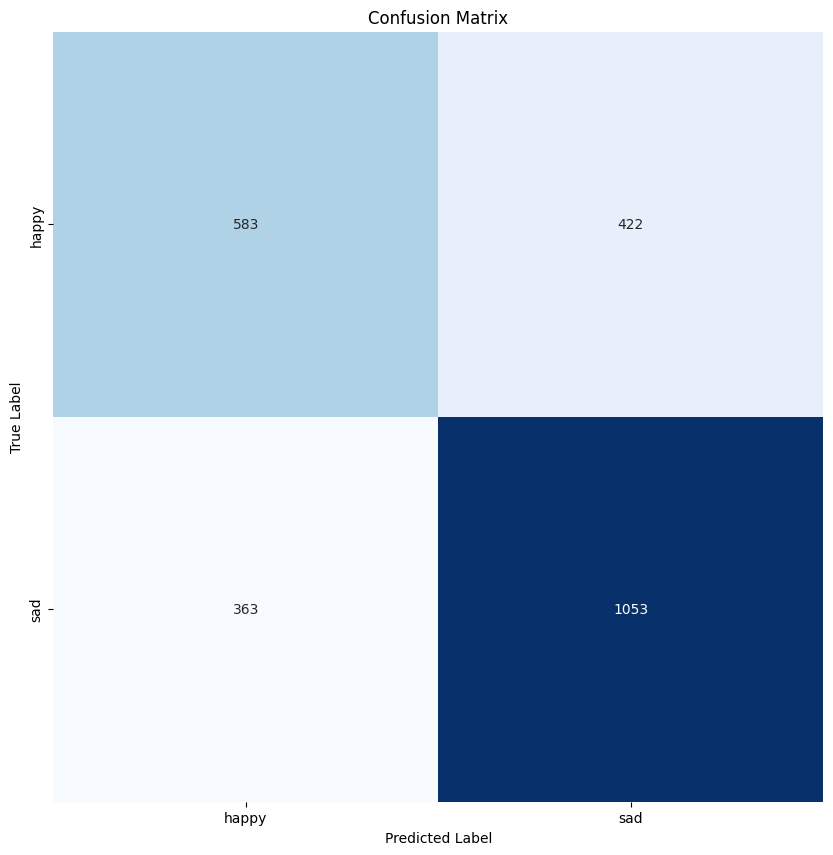

In [280]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import seaborn as sns


# Dokonaj predykcji na zbiorze testowym
predictions2 = model2.predict(test_generator)

# Przekształć predykcje na etykiety (0 lub 1)
predicted_labels2 = np.argmax(predictions2, axis=1)

accuracy_test2 = accuracy_score(y_test, predicted_labels2)
print("Test accuracy:", accuracy_test2)

# Oblicz macierz pomyłek
conf_mat2 = confusion_matrix(y_true=y_test, y_pred=predicted_labels2)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat2, annot=True, fmt="d", cmap="Blues", square=True, cbar=False,
            xticklabels=["happy", "sad"], yticklabels=["happy", "sad"])

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix")

plt.show()

### Testowe accuracy dla modelu 2 baz danych 1
Wynosi mniej niż dla modelu 1, jednak spodziewałam się tego, ponieważ ta klasyfikacja jest mniej efektywna dla zdjęć.

Poniżej przykładowe próby zgadnięcia emocji przez model 2. Jesteśmy w stanie zauważyć gołym okiem, że model ma większe trudności z odgadnięciem poprawnej odpowiedzi.

1/1 [==============================] - 0s 28ms/step


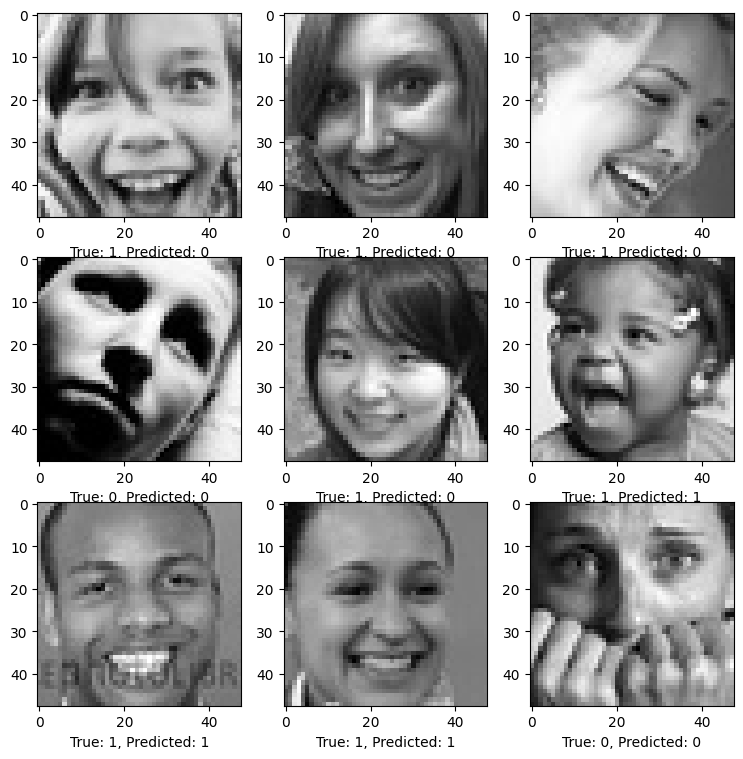

In [281]:
from tensorflow.keras.preprocessing.image import array_to_img
import random

def predict_category(model, img_array):
    img_array2 = np.expand_dims(img_array, axis=0)
    prediction2 = model2.predict(img_array2)
    return np.argmax(prediction2)

# Weź ranodmowe 9 próbek

sample_test_images2 = X_test[100:109]
sample_test_labels2 = y_test[100:109]

plt.figure(figsize=(9,9))

for index, (img_array, true_category) in enumerate(zip(sample_test_images2, sample_test_labels2)):
    img = array_to_img(img_array)
    predicted_category = predict_category(model2, img_array / 255.0)
    
    plt.subplot(3, 3, index + 1)
    plt.imshow(img)
    plt.xlabel(f"True: {true_category}, Predicted: {predicted_category}")

plt.show()


# Model 3 dla bazy danych 1
K-Najbliższych Sąsiadów 
Model 3 to klasyfikator k-NN (k najbliższych sąsiadów) zaimplementowany za pomocą biblioteki scikit-learn. Klasyfikator k-NN jest prostym algorytmem uczenia maszynowego opartym na technice statystycznej.

Do tego problemu, musimy najpierw przekształcić obrazy do jednowymiarowych wektorów

Accuracy for KNN model (model3): 0.6381660470879802


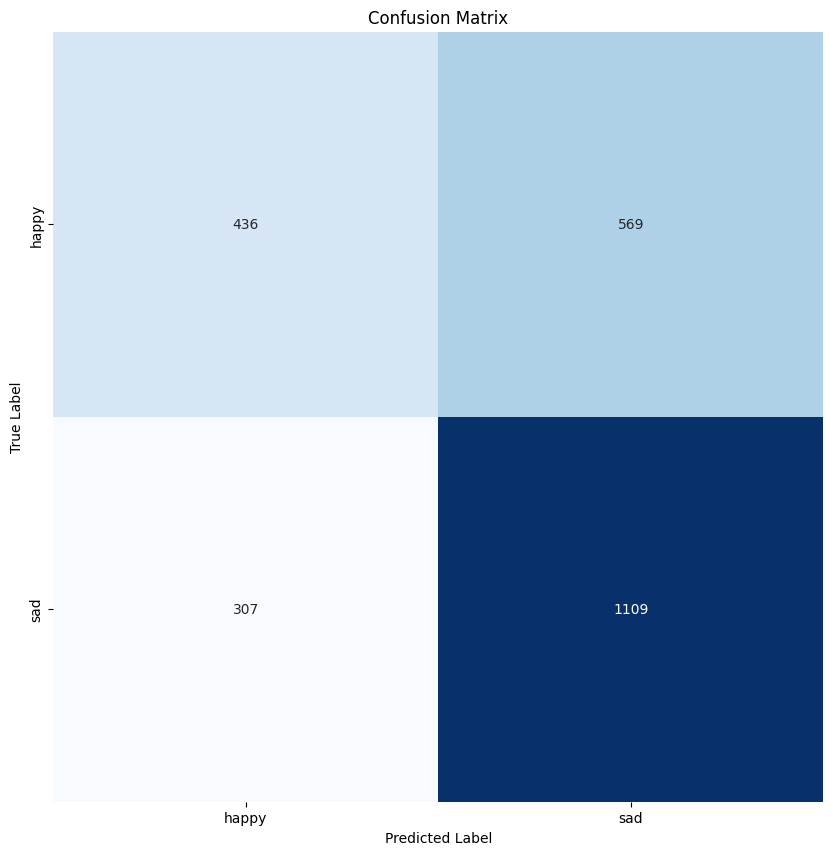

In [282]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

# Przekształć dane do jednowymiarowych wektorów
X_train_flat = X_train_temp.reshape(X_train_temp.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Stwórz instancję klasyfikatora KNN
knn = KNeighborsClassifier(n_neighbors=5)  # Możesz zmienić liczbę sąsiadów

# Dopasuj klasyfikator do danych treningowych
knn.fit(X_train_flat, y_train_temp) 

# Dokonaj predykcji na zbiorze testowym
predicted_labels3 = knn.predict(X_test_flat)

# Oblicz dokładność
accuracy3 = accuracy_score(y_test, predicted_labels3)
print("Accuracy for KNN model (model3):", accuracy3)

# Oblicz macierz pomyłek
conf_mat3 = confusion_matrix(y_true=y_test, y_pred=predicted_labels3)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat3, annot=True, fmt="d", cmap="Blues", square=True, cbar=False,
            xticklabels=["happy", "sad"], yticklabels=["happy", "sad"])

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix")

plt.show()


### Test accuracy model 2 baza danych 1
Accuracy testowe jest porównywalne dla modelu 2.

# Przygotowywanie drugiej bazy danych

Druga baza danych jest przeprocesowana przez pare kroków:
- konwersja na tablicę numpy
- konwersja na obraz jednokanałowy
- rozmycie Gaussowskie (zmniejsza szum i detale na obrazie, co może pomóc w poprawie wydajności modelu)
- Wyrównanie histogramu (Histogram obrazu jest wyrównywany za pomocą funkcji equalizeHist z OpenCV, która zwiększa kontrast obrazu, co może pomóc w poprawie wykrywania cech)
- Dodawanie dodatkowego wymiaru

In [283]:
import numpy as np


import cv2

def gaussian_blur(image, kernel_size=(3, 3)):
    return cv2.GaussianBlur(image, kernel_size, 0)


def equalize_histogram(image):
    return cv2.equalizeHist(image)

def preprocess_image(image):
    # Konwersja na tablicę NumPy
    image = np.array(image)

    # Konwersja na obraz jednokanałowy, jeśli ma więcej niż jeden kanał
    if image.ndim == 3 and image.shape[2] > 1:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Rozmycie Gaussowskie
    image = gaussian_blur(image)

    # Wyrównanie histogramu
    image = equalize_histogram(image)

    # Dodaj dodatkowy wymiar dla kanału obrazów w skali szarości
    image = np.expand_dims(image, axis=-1)

    return image



Tym razem ładujemy dane wraz z funkcją preprocess_image.

In [284]:
# Preparing data 2
def load_images_labels2(folder_path, label):
    images2 = []
    labels2 = []
    for filename in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, filename))
        if img is not None:
            img = preprocess_image(img)
            images2.append(img)
            labels2.append(label)
    return images2, labels2


sad_images2, sad_labels2 = load_images_labels2(sad_path, 0)
happy_images2, happy_labels2 = load_images_labels2(happy_path, 1)

images2 = sad_images2 + happy_images2
labels2 = sad_labels2 + happy_labels2

X2 = np.array(images2)
Y2 = np.array(labels2)
print(X2.shape, Y2.shape)

(12102, 48, 48, 1) (12102,)


Poniżej przykład jak wygląda przykładowe zdjęcie po obróbce.

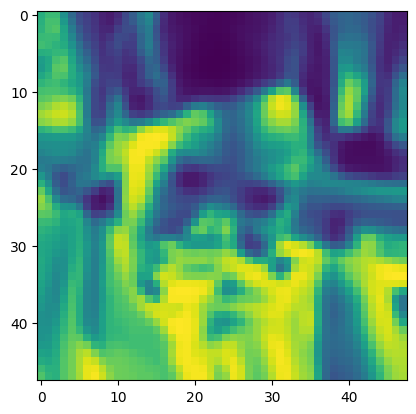

In [285]:
import random
plt.imshow(random.choice(X2))
# plt.imshow(random.choice(Y2))

In [286]:
train_datagen2 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen2 = ImageDataGenerator(rescale=1./255) # bez augmentacji, tylko normalizacja


In [287]:
# Podział dane na zbiór uczący, walidacyjny i testowy
X_train_temp2, X_val_test2, y_train_temp2, y_val_test2 = train_test_split(X2, Y2, test_size=0.4, random_state=42)
X_val2, X_test2, y_val2, y_test2 = train_test_split(X_val_test2, y_val_test2, test_size=0.5, random_state=42)

# Dopasowanie generatorów do danych
train_generator2 = train_datagen.flow(X_train_temp2, y_train_temp2, batch_size=32)
val_generator2 = test_datagen.flow(X_val2, y_val2, batch_size=32)
test_generator2 = test_datagen.flow(X_test2, y_test2, batch_size=32, shuffle=False)



Ukazanie jak przeskalowane są obrazy.

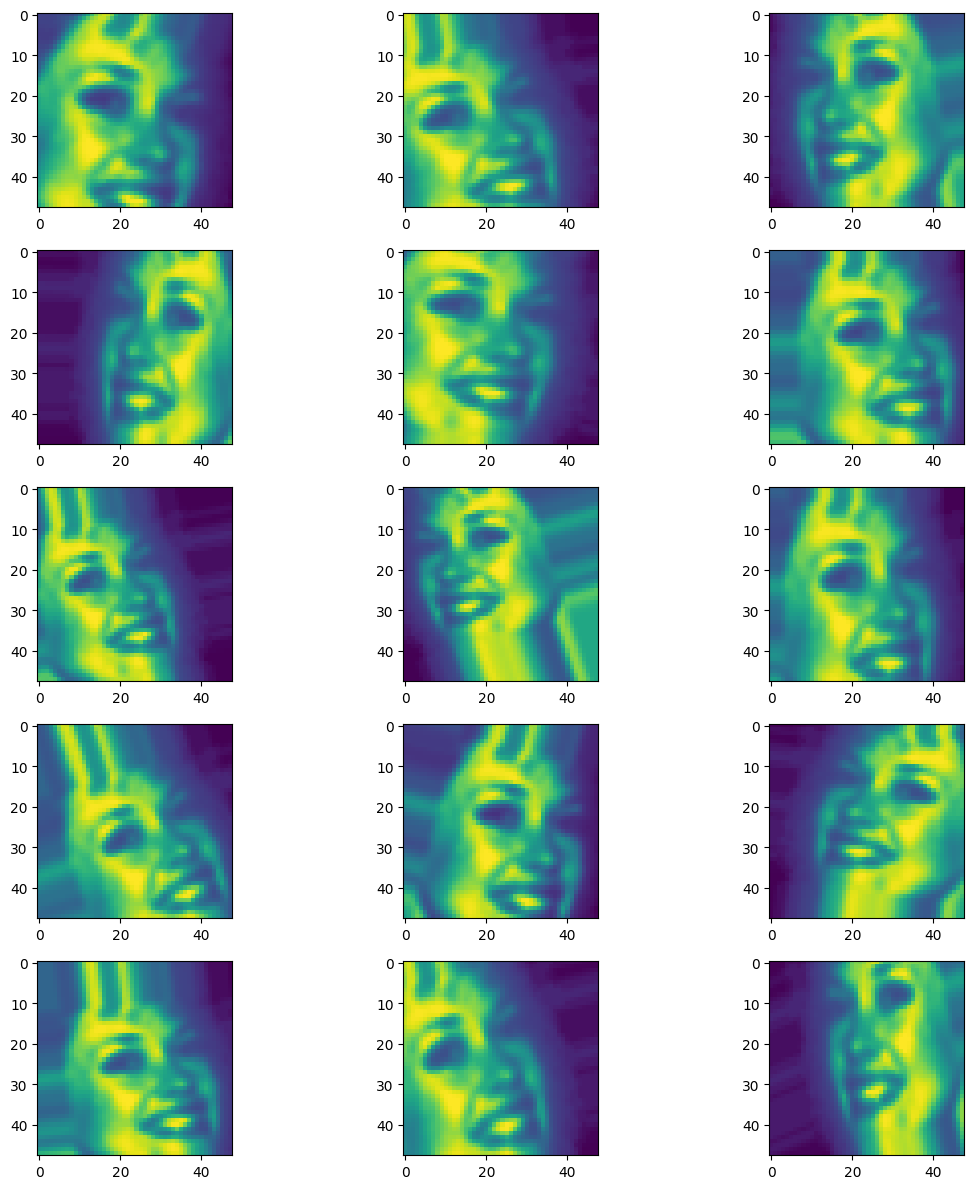

In [288]:
import numpy as np
import matplotlib.pyplot as plt

def plot_transformed_single_image(train_datagen, X_train, image_index, num_transformations=15):
    # Pobierz oryginalny obrazek z danych treningowych
    original_image = X_train[image_index]

    # Stworzenie generatora opartego na jednym obrazku
    single_image_gen = train_datagen.flow(np.array([original_image]))

    plt.figure(figsize=(12, 12))
    for i in range(num_transformations):
        plt.subplot(5, 3, i + 1)
        transformed_image = single_image_gen.next()[0]
        plt.imshow(transformed_image.squeeze())
    plt.tight_layout()
    plt.show()

# Wybierz losowy indeks obrazka
random_image_index = np.random.randint(0, len(X_train_temp2))

# Wywołaj funkcję, aby wyświetlić różne wersje przekształceń dla jednego obrazka
plot_transformed_single_image(train_datagen2, X_train_temp2, random_image_index)


### Model 2 dla bazy danych 2
Najbardziej znany i efektywny model do nauki sieci neuronowej zdjęć jest CNN - konwolucyjna sieć neuronowa.
Kroki:
- Pierwsza warstwa konwolucyjna: 32 filtry o rozmiarze 3x3 są stosowane na obrazie wejściowym. Funkcja aktywacji ReLU (Rectified Linear Unit) dodaje nieliniowość do modelu, co pozwala na uczenie się bardziej złożonych wzorców.
- Pierwsza warstwa MaxPooling: Zmniejsza rozmiar map cech z poprzedniej warstwy, wybierając maksymalną wartość z okien o rozmiarze 2x2. To pomaga w redukcji liczby parametrów modelu i zmniejsza ryzyko przeuczenia.
- Druga warstwa konwolucyjna: 64 filtry o rozmiarze 3x3 są stosowane na wynikach pierwszej warstwy MaxPooling. Ponownie używana jest funkcja aktywacji ReLU.
- Druga warstwa MaxPooling: Analogicznie do pierwszej warstwy MaxPooling, również ta warstwa redukuje rozmiar map cech z poprzedniej warstwy.
- Trzecia warstwa konwolucyjna: 128 filtry o rozmiarze 3x3 są stosowane na wynikach drugiej warstwy MaxPooling, z funkcją aktywacji ReLU.
- Trzecia warstwa MaxPooling: Kolejne zmniejszenie rozmiaru map cech z poprzedniej warstwy.
- Warstwa Flatten: Spłaszcza dane z poprzedniej warstwy, konwertując wielowymiarowe mapy cech na jednowymiarowy wektor, który może być przekazywany do warstw Dense (gęstych).
- Warstwa Dense: Składa się z 128 neuronów z funkcją aktywacji ReLU. Ta warstwa pozwala na uczenie się kombinacji cech z poprzednich warstw.
- Warstwa Dropout: Odrzuca losowo 50% neuronów podczas uczenia, co pomaga w zmniejszeniu ryzyka przeuczenia.
- Warstwa wyjściowa: Warstwa Dense z jednym neuronem i funkcją aktywacji sigmoidalną. Sigmoid jest używany w przypadku problemów klasyfikacji binarnej i zwraca prawdopodobieństwo przynależności do jednej z klas.



W podanym przykładzie model jest kompilowany z optymalizatorem `adam`, funkcją straty `binary_crossentropy` (stosowaną w klasyfikacji binarnej) oraz metryką `accuracy` (dokładność), która będzie monitorowana podczas uczenia.

In [289]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

input_shape = X_train_temp2.shape[1:]

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

input_shape = X_train_temp2.shape[1:]

model2_1 = Sequential([
    # Pierwsza warstwa konwolucyjna
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Druga warstwa konwolucyjna
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Trzecia warstwa konwolucyjna
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Spłaszczanie danych i dodanie warstw Dense
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    
    # Warstwa wyjściowa
    Dense(1, activation='sigmoid')
])

# Kompilacja model2_1u
model2_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Podsumowanie model2_1u
model2_1.summary()



Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 10, 10, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 4, 4, 128)      

In [290]:
# Liczba próbek podzielona przez rozmiar wsadu
steps_per_epoch2 = len(X_train_temp2) // 32
validation_steps2 = len(X_val2) // 32
history2_1 = model2_1.fit(train_generator2, 
                    epochs=LICZBA_EPOK,
                    validation_data=val_generator2,
                    validation_steps=validation_steps2
    )


Epoch 1/100
227/227 [==============================] - 13s 51ms/step - loss: 0.6805 - accuracy: 0.5903 - val_loss: 0.6755 - val_accuracy: 0.5925
Epoch 2/100
227/227 [==============================] - 11s 47ms/step - loss: 0.6776 - accuracy: 0.5943 - val_loss: 0.6729 - val_accuracy: 0.5917
Epoch 3/100
227/227 [==============================] - 11s 46ms/step - loss: 0.6732 - accuracy: 0.5937 - val_loss: 0.6729 - val_accuracy: 0.5917
Epoch 4/100
227/227 [==============================] - 11s 47ms/step - loss: 0.6697 - accuracy: 0.5940 - val_loss: 0.6566 - val_accuracy: 0.5917
Epoch 5/100
227/227 [==============================] - 11s 47ms/step - loss: 0.6629 - accuracy: 0.5952 - val_loss: 0.6390 - val_accuracy: 0.6204
Epoch 6/100
227/227 [==============================] - 11s 47ms/step - loss: 0.6617 - accuracy: 0.6034 - val_loss: 0.6118 - val_accuracy: 0.6242
Epoch 7/100
227/227 [==============================] - 11s 48ms/step - loss: 0.6354 - accuracy: 0.6229 - val_loss: 0.6123 - val_ac

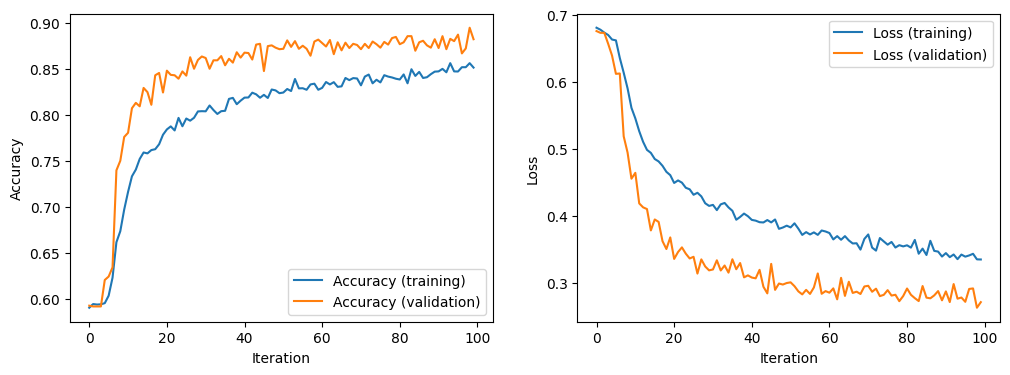

In [291]:
# Plots of accuracy and loss
plt.figure(figsize=(12, 4))
# plt.title("Baza danych 1 Model 1")
plt.subplot(1, 2, 1)
plt.plot(history2_1.history['accuracy'], label='Accuracy (training)')
plt.plot(history2_1.history['val_accuracy'], label='Accuracy (validation)')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history2_1.history['loss'], label='Loss (training)')
plt.plot(history2_1.history['val_loss'], label='Loss (validation)')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

76/76 [==============================] - 1s 13ms/step
Test accuracy: 0.8934324659231723


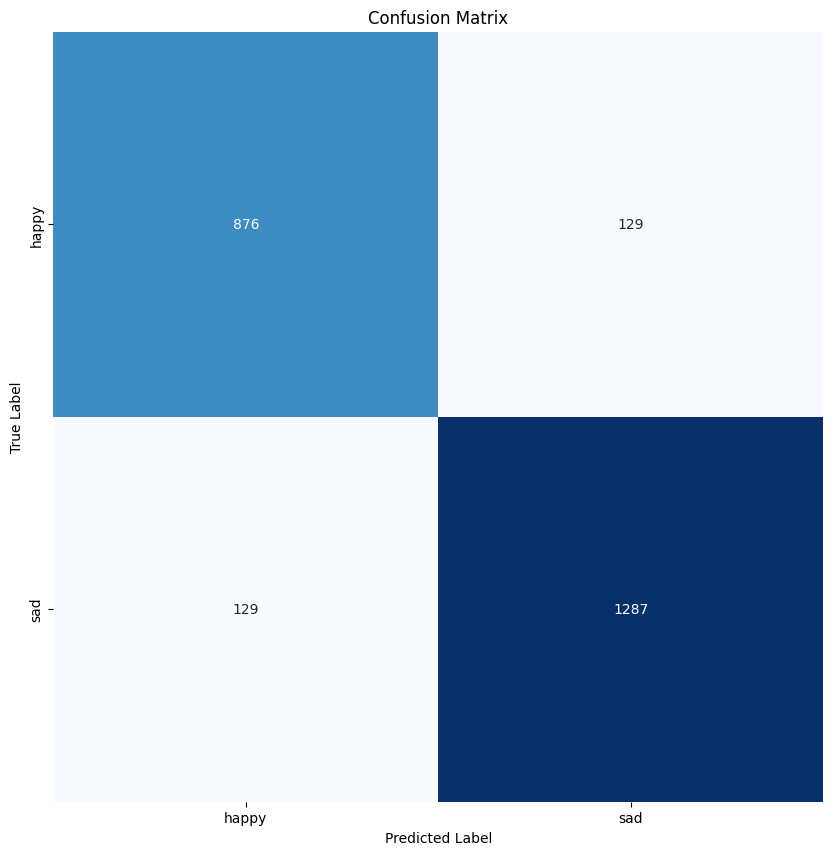

In [292]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import seaborn as sns


# Dokonaj predykcji na zbiorze testowym
predictions = model2_1.predict(test_generator2)

# Przekształć predykcje na etykiety (0 lub 1)
predicted_labels = np.argmax(predictions, axis=1)
# Przekształć predykcje na etykiety (0 lub 1)
predicted_labels = (predictions > 0.5).astype(int).flatten()

accuracy_test = accuracy_score(y_test2, predicted_labels)
print("Test accuracy:", accuracy_test)


# Oblicz macierz pomyłek
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted_labels)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", square=True, cbar=False,
            xticklabels=["happy", "sad"], yticklabels=["happy", "sad"])

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix")

plt.show()

Model ten okazał się bardzo stabilny i ma wysokie `accuracy test`, czego spodziewaliśmy się przy konwulacyjnej sieci neuronowej.

Poniżej przykłady zgadywania modelu na zbiorze testowym.

1/1 [==============================] - 0s 30ms/step


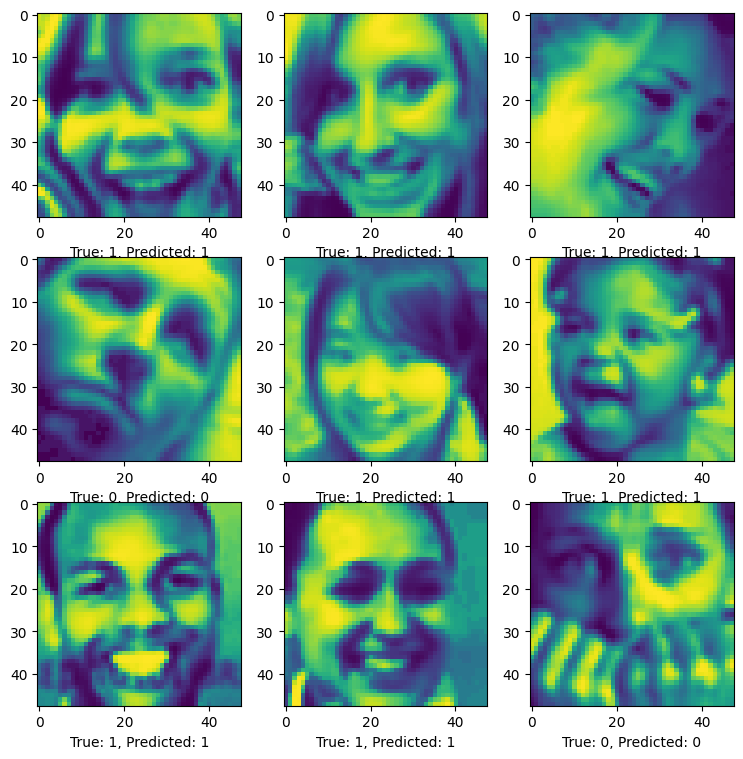

In [293]:
from tensorflow.keras.preprocessing.image import array_to_img
import random

def predict_category(model, img_array):
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    return (prediction > 0.5).astype(int).flatten()[0]

# Weź losowe 9 próbek
sample_test_images = X_test2[100:109]
sample_test_labels = y_test2[100:109]

plt.figure(figsize=(9,9))

for index, (img_array, true_category) in enumerate(zip(sample_test_images, sample_test_labels)):
    img = array_to_img(img_array)
    predicted_category = predict_category(model2_1, img_array / 255.0)
    
    plt.subplot(3, 3, index + 1)
    plt.imshow(img)
    plt.xlabel(f"True: {true_category}, Predicted: {predicted_category}")

plt.show()


# Model 2 dla bazy danych 2
Jednym ze znanych modelu do nauki sieci neuronowych jest DNN - głęboka sieć neuronowa.
Zastosowanie modelu "każdy piksel obrazka to neuron wejściowy" oznacza, że będziemy używać warstwy Dense zamiast warstw konwolucyjnych. W tym przypadku sieć neuronowa będzie bardziej "płaska" (bez hierarchii).

Kroki:
- Wejściowa warstwa Dense (Flatten + Dense): Na początku, sieć spłaszcza dane wejściowe za pomocą warstwy Flatten, która przekształca dane o kształcie obrazka na jednowymiarowy wektor. Następnie, stosuje warstwę Dense z tyloma neuronami, ile jest pikseli na obrazku, z funkcją aktywacji ReLU.

- Normalizacja wsadowa: Następnie stosuje warstwę BatchNormalization, która normalizuje dane wejściowe, przyspieszając uczenie i poprawiając stabilność procesu uczenia.

- Dodatkowe warstwy Dense: W kolejnym kroku, sieć ma trzy warstwy Dense o różnych wielkościach (512, 256, 128), z funkcją aktywacji ReLU. Każda z nich jest poprzedzona warstwą BatchNormalization.

- Warstwy Dropout: Po każdej warstwie Dense (oprócz pierwszej), stosowana jest warstwa Dropout z wartością 0.5. Warstwy Dropout pomagają zapobiegać przetrenowaniu sieci neuronowej przez czasowe wyłączanie części neuronów podczas procesu uczenia.

- Warstwa wyjściowa: Na końcu modelu znajduje się warstwa Dense z jednym neuronem i funkcją aktywacji sigmoid. Ta warstwa odpowiada za generowanie wyniku klasyfikacji binarnej. 

 Model jest kompilowany z optymalizatorem `RMSprop` o współczynniku uczenia 0.001, funkcją straty '`binary_crossentropy`' oraz metryką '`accuracy`'.

In [294]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop


input_shape = X_train_temp2.shape[1:]

# Oblicz liczbę neuronów wejściowych jako iloczyn wymiarów obrazka
num_input_neurons = np.prod(input_shape)

model2_2 = Sequential([
    # Wejściowa warstwa Dense z tyloma neuronami, ile jest pikseli na obrazku
    Flatten(input_shape=input_shape),
    Dense(num_input_neurons, activation='relu'),
    BatchNormalization(),
    
    # Dodatkowe warstwy Dense
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    # Warstwa wyjściowa
    Dense(1, activation='sigmoid')
])

# Kompilacja modelu z innym optymalizatorem
model2_2.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Podsumowanie modelu
model2_2.summary()

# Trenowanie modelu z normalizacją danych
# train_generator2_norm = train_datagen2.flow(X_train_temp2 / 255.0, y_train_temp2, batch_size=32)
# test_generator2_norm = test_datagen2.flow(X_test2 / 255.0, y_test2, batch_size=32)

history2_2 = model2_2.fit(train_generator2, 
                    epochs=LICZBA_EPOK,
                    validation_data=val_generator2,
                    validation_steps=validation_steps2)


Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_28 (Flatten)        (None, 2304)              0         
                                                                 
 dense_94 (Dense)            (None, 2304)              5310720   
                                                                 
 batch_normalization_70 (Bat  (None, 2304)             9216      
 chNormalization)                                                
                                                                 
 dense_95 (Dense)            (None, 512)               1180160   
                                                                 
 batch_normalization_71 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_74 (Dropout)        (None, 512)             

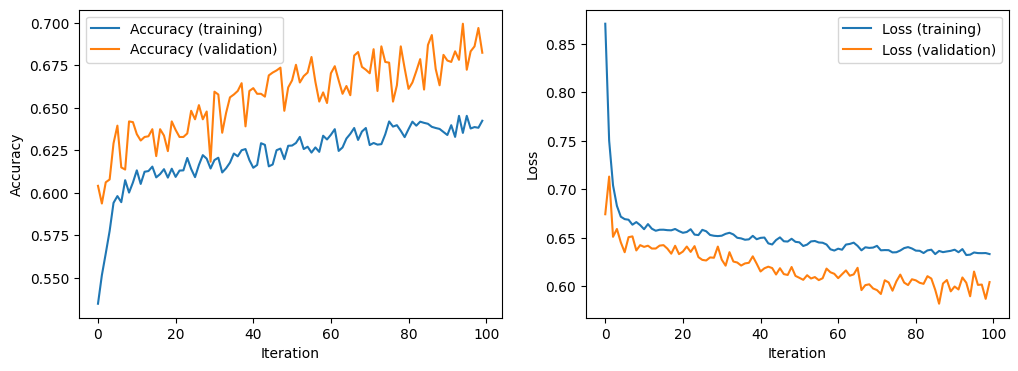

In [295]:
# Plots of accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history2_2.history['accuracy'], label='Accuracy (training)')
plt.plot(history2_2.history['val_accuracy'], label='Accuracy (validation)')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Accuracy')


plt.subplot(1, 2, 2)
plt.plot(history2_2.history['loss'], label='Loss (training)')
plt.plot(history2_2.history['val_loss'], label='Loss (validation)')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

76/76 [==============================] - 1s 10ms/step
Test accuracy: 0.677819083023544


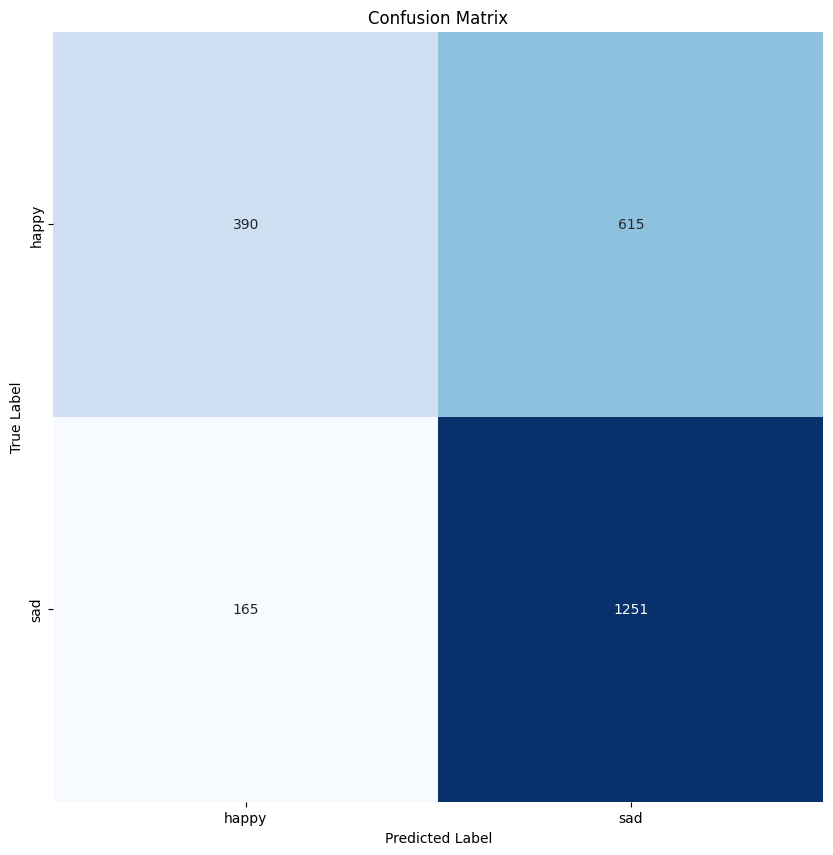

In [296]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import seaborn as sns

# Dokonaj predykcji na zbiorze testowym
predictions2 = model2_2.predict(test_generator2)

# Przekształć predykcje na etykiety (0 lub 1)
predicted_labels2 = (predictions2 > 0.5).astype(int).flatten()

accuracy_test = accuracy_score(y_test2, predicted_labels2)
print("Test accuracy:", accuracy_test)


# Oblicz macierz pomyłek
conf_mat2 = confusion_matrix(y_true=y_test2, y_pred=predicted_labels2)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat2, annot=True, fmt="d", cmap="Blues", square=True, cbar=False,
            xticklabels=["happy", "sad"], yticklabels=["happy", "sad"])

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix")

plt.show()


`Test accuracy` jest znacząco słabsze niż dla modelu 1, jednak lepsze niż dla bazy danych 1.

# Model 3 dla bazy danych 1
K-Najbliższych Sąsiadów 
Model 3 to klasyfikator k-NN (k najbliższych sąsiadów) zaimplementowany za pomocą biblioteki scikit-learn. Klasyfikator k-NN jest prostym algorytmem uczenia maszynowego opartym na technice statystycznej.

Accuracy: 0.654275092936803


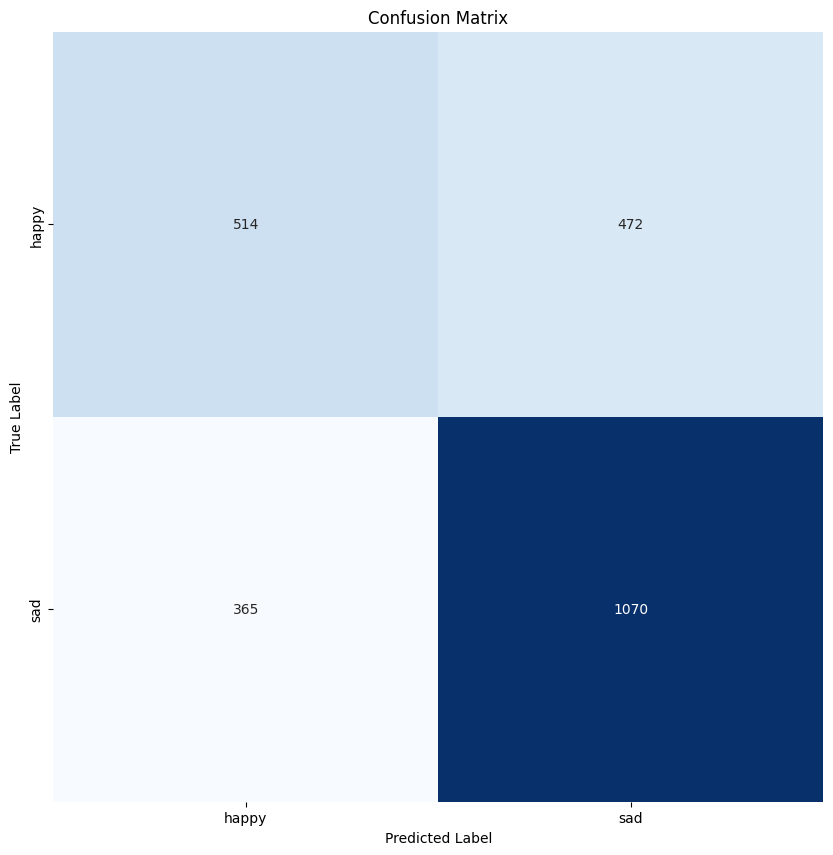

In [297]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# Spłaszczanie obrazów
X_flat = X2.reshape(X2.shape[0], -1)

# Podział na zestawy treningowe i testowe
X_train_flat, X_test_flat, y_train_flat, y_test_flat = train_test_split(X_flat, Y2, test_size=0.2, random_state=42)

# Stworzenie i wytrenowanie modelu k-NN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_flat, y_train_flat)

# Dokonaj predykcji na zbiorze testowym
y_pred = knn.predict(X_test_flat)

# Obliczenie accuracy
accuracy = accuracy_score(y_test_flat, y_pred)
print(f"Accuracy: {accuracy}")

# Oblicz macierz pomyłek
conf_mat_knn = confusion_matrix(y_test_flat, y_pred)

# Wizualizacja macierzy pomyłek
plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat_knn, annot=True, fmt="d", cmap="Blues", square=True, cbar=False,
            xticklabels=["happy", "sad"], yticklabels=["happy", "sad"])
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix")
plt.show()


`Test accuracy` jest lekko lepsze niż dla bazy danych 11

# Podsumowanie

Najważniejszym aspektem sieci neuronowej jest jej skuteczność. Sprawdza się ją przy pomocy bazy testowej i określa za pomocą wartości 0 - 1 lub w procentach. Poniżej przedstawiam tabelkę, w której jest przyrównanie wszystkich `test accuracy` dla różnych modeli i dwóch baz danych.

| Model      | Baza danych nieprzetworzona     | Baza danych przetworzona |
| ------------- |:-------------------:| -----:|
| CNN   | 0.9008674101610905 | 0.8934324659231723|
| DNN  | 0.6757538207352334       | 0.677819083023544 |
| KNN | 0.6381660470879802    |  0.654275092936803|

### Wnioski
- Mimo przetworzenia bazy danych poprawność zgadywania modeli była bardzo porównywalna. Dla modelu CNN dla przetworzonej bazy danych poprawność była lekko słabsza, a dla KNN dla przetworzonej bazy danych była lekko lepsza.

- Zdecydowanie najlepiej poradziły sobie modele z klasyfikacją `CNN`. Spodziewaliśmy się tego wyniku.

- `DNN` poradziło sobie drugorzędnie

- `KNN ` wypadło najsłabiej ze wszystkich klasyfikatorów.